In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/hw4")

In [3]:
import csv

In [4]:
train, dev, test = [], [], []

In [5]:
with open('./data/pnli_train.csv', encoding='utf-8') as fp:
    csvreader = csv.reader(fp)
    for x in csvreader:
        # x[2] will be the label (0 or 1). x[0] and x[1] will be the sentence pairs.
        train.append(x)
print (len(train))
print (train[:3])

5983
[['Sometimes do exercise.', 'A person typically desire healthy life.', '1'], ['Who eats junk foods.', 'A person typically desire healthy life.', '0'], ['A person is sick.', 'A person typically desire healthy life.', '1']]


In [6]:
with open('./data/pnli_dev.csv', encoding='utf-8') as fp:
    csvreader = csv.reader(fp)
    for x in csvreader:
        # x[2] will be the label (0 or 1). x[0] and x[1] will be the sentence pairs.
        dev.append(x)
print (len(dev))
print (dev[:3])

1055
[['A person is looking for accuracy.', 'A person typically desires accurate results.', '1'], ['A person does not care for accuracy.', 'A person typically desires accurate results.', '0'], ['The person double checks their data.', 'A person typically desires accurate results.', '1']]


In [7]:
with open('./data/pnli_test_unlabeled.csv', encoding='utf-8') as fp:
    csvreader = csv.reader(fp)
    for x in csvreader:
        # x[0] and x[1] will be the sentence pairs.
        test.append(x)
print (len(test))
print (test[:3])

4850
[['The people want to have a romantic and pleasant feel.', 'People typically does desire to smell violets.'], ['The contract is to buy products from you.', 'Getting contract typically cause to make money or spend money.'], ['Train station is closed.', 'Line can typically be used to move train along tracks.']]


In [8]:
!pip install transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 32.1 MB/s 
     |████████████████████████████████| 163 kB 70.3 MB/s 
     |████████████████████████████████| 6.6 MB 52.5 MB/s 


In [9]:
import pandas as pd
import numpy as np
import os
import time
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [10]:

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import transformers
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import AdamW

import warnings
warnings.filterwarnings("ignore")

In [11]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [12]:
MODEL_TYPE = 'roberta-base'
L_RATE = 2e-5
MAX_LEN = 128
NUM_EPOCHS = 4
BATCH_SIZE = 32
NUM_CORES = os.cpu_count()

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
# Creating the Data Loader Object
class DataLoaderForTrainAndVal(Dataset):
    def __init__(self, datas):
        self.datas = datas

    def __getitem__(self, index):
        final_tokenized_result=[]

        condition = self.datas[index][0]
        outcome = self.datas[index][1]

        tokenized_result = tokenizer.encode_plus(
                    condition, outcome,           
                    add_special_tokens = True,      
                    max_length = MAX_LEN,           
                    pad_to_max_length = True,
                    truncation=True,
                    return_attention_mask = True,   
                    return_tensors = 'pt',
               )  
        input_ids = tokenized_result['input_ids'][0]
        attention_mask = tokenized_result['attention_mask'][0]
        
        label_tensors = torch.tensor(np.int64(self.datas[index][2]))

        final_tokenized_result.append(input_ids)
        final_tokenized_result.append(attention_mask)
        final_tokenized_result.append(label_tensors)

        return final_tokenized_result
    

    def __len__(self):
        return len(self.datas)


In [15]:
class DataLoaderForTest(Dataset):
    def __init__(self, datas):
        self.datas = datas

    def __getitem__(self, index):
        final_tokenized_result=[]

        condition = self.datas[index][0]
        outcome = self.datas[index][1]

        tokenized_result = tokenizer.encode_plus(
                    condition, outcome,           
                    add_special_tokens = True,      
                    max_length = MAX_LEN,
                    truncation=True,           
                    pad_to_max_length = True,
                    return_attention_mask = True,   
                    return_tensors = 'pt',          
               )
        input_ids = tokenized_result['input_ids'][0]
        attention_mask = tokenized_result['attention_mask'][0]
        final_tokenized_result.append(input_ids)
        final_tokenized_result.append(attention_mask)
        return final_tokenized_result


    def __len__(self):
        return len(self.datas)

In [16]:
model = RobertaForSequenceClassification.from_pretrained(MODEL_TYPE, num_labels = 2)
model.to(device)

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [17]:
optimizer = AdamW(model.parameters(),
              lr = L_RATE, 
              eps = 1e-8)

In [18]:
# Create the dataloaders.
def getDataLoader(data,data_type):
  if data_type=="test":
    data_for_loader = DataLoaderForTest(data)
    dataloader = torch.utils.data.DataLoader(data_for_loader, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_CORES)
  if data_type=="train" or data_type=="val":
    data_for_loader = DataLoaderForTrainAndVal(data)
    dataloader = torch.utils.data.DataLoader(data_for_loader, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_CORES)
  return dataloader

In [19]:
train_dataloader=getDataLoader(train,"train")
val_dataloader=getDataLoader(dev,"val")

In [20]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Accuracies
training_accuracies=[]
validation_accuracies=[]

# Loss 
training_losses=[]
validation_losses=[]

for epoch in range(0, NUM_EPOCHS):
    start = time.time()

    targets_list_train = []
    targets_list_val=[]

    print('Training...')
    
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0

    for i, batch in enumerate(train_dataloader):

        input_ids_batch,attention_mask_batch,targets_batch= batch[0].to(device),batch[1].to(device),batch[2].to(device)  
        
        model.zero_grad()        
        
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch, labels=targets_batch)  

        loss,train_preds = outputs.loss,outputs.logits
        
        total_train_loss += loss.item()
        

        train_preds = train_preds.detach().cpu().numpy()       
        targets_np = targets_batch.to('cpu').numpy()
        targets_list_train.extend(targets_np)

        stacked_train_preds = train_preds if i == 0 else np.vstack((stacked_train_preds, train_preds))
        
        optimizer.zero_grad()
      
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step() 


    y_true_train = targets_list_train
    y_pred_train = np.argmax(stacked_train_preds, axis=1)
    
    train_acc = accuracy_score(y_true_train, y_pred_train)
    print(f'Epoch {epoch+1}: train_loss: {total_train_loss} train_acc: {train_acc}')

    training_accuracies.append(train_acc)
    training_losses.append(total_train_loss)
    print('\n Validation Process...')
    model.eval()

    torch.set_grad_enabled(False)

    total_val_loss = 0
    

    for j, batch in enumerate(val_dataloader):
        
        input_ids_val,attention_mask_val,labels_val = batch[0].to(device),batch[1].to(device),batch[2].to(device)
        
        val_outputs = model(input_ids_val, attention_mask=attention_mask_val, labels=labels_val)
        
        loss = val_outputs[0]
        
        total_val_loss += loss.item()
        
        preds = val_outputs[1]

        val_preds = preds.detach().cpu().numpy()
        targets_np = labels_val.to('cpu').numpy()
        targets_list_val.extend(targets_np)

        stacked_val_preds = val_preds if j == 0 else np.vstack((stacked_val_preds, val_preds))

    
    # Calculating the the validation accuracy
    y_true_val = targets_list_val
    y_pred_val = np.argmax(stacked_val_preds, axis=1)
    
    val_acc = accuracy_score(y_true_val, y_pred_val)
    
    print(f'Epoch {epoch+1}: Validation Loss: {total_val_loss} Validation Accuracy: {val_acc}')
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

    validation_accuracies.append(val_acc)
    validation_losses.append(total_val_loss)


Training...
Epoch 1: train_loss: 95.0446958988905 train_acc: 0.7501253551729902

 Validation Process...
Epoch 1: Validation Loss: 12.934342131018639 Validation Accuracy: 0.8473933649289099
00:02:05.03
Training...
Epoch 2: train_loss: 63.50693303346634 train_acc: 0.862945010864115

 Validation Process...
Epoch 2: Validation Loss: 11.256900832057 Validation Accuracy: 0.8701421800947867
00:02:10.37
Training...
Epoch 3: train_loss: 47.88053669035435 train_acc: 0.9055657696807622

 Validation Process...
Epoch 3: Validation Loss: 11.399029556661844 Validation Accuracy: 0.8815165876777251
00:02:12.44
Training...
Epoch 4: train_loss: 36.83013304043561 train_acc: 0.9323082065853251

 Validation Process...
Epoch 4: Validation Loss: 11.647796895354986 Validation Accuracy: 0.8720379146919431
00:02:12.49


In [21]:
test_dataloader=getDataLoader(test,"test")
print(len(test_dataloader))

152


In [22]:
print("The value is",(next(iter(train_dataloader))))

The value is [tensor([[    0,  1185,    33,  ...,     1,     1,     1],
        [    0,  1185,    32,  ...,     1,     1,     1],
        [    0,   250,   621,  ...,     1,     1,     1],
        ...,
        [    0,  1185,   416,  ...,     1,     1,     1],
        [    0,   133, 16381,  ...,     1,     1,     1],
        [    0,   970,    16,  ...,     1,     1,     1]]), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), tensor([0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 1, 1])]


In [23]:
def calculateOutput(test_dataloader):
  model.to(device)
  model.eval()
  torch.set_grad_enabled(False)

  for i, batch in tqdm(enumerate(test_dataloader)):
    input_ids,attention_mask = batch[0].to(device),batch[1].to(device)
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs[0]
    final_preds = logits.detach().cpu().numpy()
    stacked_final_preds = final_preds if i==0 else np.vstack((stacked_final_preds, final_preds)) 
  return stacked_final_preds

In [24]:
stacked_final_preds=calculateOutput(test_dataloader)

152it [00:33,  4.53it/s]


In [25]:
test_preds = np.argmax(stacked_final_preds, axis=1)

In [26]:
print(len(test_preds))
print(test_preds[:10])

4850
[1 1 0 0 0 0 0 1 0 0]


In [27]:
print(test_preds[:10])

[1 1 0 0 0 0 0 1 0 0]


In [28]:
results=test_preds

In [29]:
# suppose you had your model's predictions on the 2028 test cases read from test_enc_unlabeled.tsv, and 
#those results are in the list called 'results'
assert (len(results) == 4850)

In [30]:
# make sure the results are not float numbers, but intergers 0 and 1
results = [int(x) for x in results]

In [31]:
# write your prediction results to 'upload_predictions.txt' and upload that later
with open('upload_predictions.txt', 'w', encoding = 'utf-8') as fp:
    for x in results:
        fp.write(str(x) + '\n')

In [32]:
import matplotlib.pyplot as plt

In [33]:
print(validation_losses)

[12.934342131018639, 11.256900832057, 11.399029556661844, 11.647796895354986]


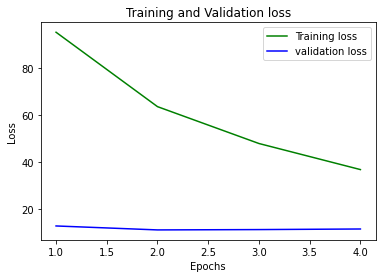

In [34]:
epochs = range(1,5)
plt.plot(epochs, training_losses, 'g', label='Training loss')
plt.plot(epochs, validation_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

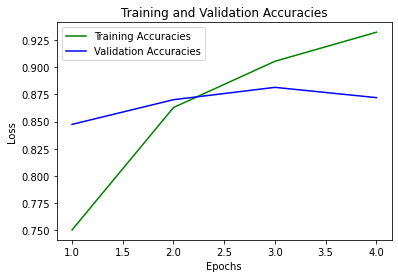

In [35]:
epochs = range(1,5)
plt.plot(epochs, training_accuracies, 'g', label='Training Accuracies')
plt.plot(epochs, validation_accuracies, 'b', label='Validation Accuracies')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()